# Retrieval Dataset Analysis Report

## 1. Methodology: Causal Relevance Verification

This report analyzes the empirical relevance of documentation for solving software engineering tasks. Instead of relying on static similarity (embeddings) or human labeling, we use **Monte Carlo Causal Inference**.

### The Algorithm
For each query $q$ and a pool of candidate documents $C(q)$:
1.  **Randomized Trials:** We execute $N$ trials. In each trial, a random subset $S \subset C(q)$ is injected into the LLM's context window.
2.  **Blind Solving:** The LLM attempts to solve the task using *only* $S$.
3.  **Impact Scoring (Delta P):** We calculate the marginal contribution of each document $d$:
    $$ \Delta P(d) = P(\text{Success} | d \in S) - P(\text{Success} | d \notin S) $$

### Interpretation
*   **$\Delta P \approx 1.0$**: **Critical**. The task cannot be solved without this document.
*   **$\Delta P > 0.1$**: **Helpful**. The document improves success rate but might be redundant with others.
*   **$\Delta P \approx 0.0$**: **Irrelevant**. The document is noise.
*   **$\Delta P < -0.1$**: **Toxic**. The document actively misleads the model (e.g., hallucination trigger).

In [1]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import os
import json
from pathlib import Path

print(f"Current Working Directory: {os.getcwd()}")
# Configure plotting
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_colwidth', 100)

Current Working Directory: /Users/ivanmkc/Documents/code/agent-generator


In [2]:
# Load Latest Run Logs (YAML Stream)
trial_events = []
convergence_events = []
trials_df = pd.DataFrame()

log_files = glob.glob("../logs/*.yaml")
if not log_files:
    # Try relative to root if running from there
    log_files = glob.glob("logs/*.yaml")

if not log_files:
    print("No log files found.")
else:
    latest_log = max(log_files, key=os.path.getctime)
    print(f"Loading logs from: {latest_log}")
    
    all_events = []
    with open(latest_log, 'r') as f:
        events = list(yaml.safe_load_all(f))
        all_events = events
    
    # Extract Trial Events
    trial_events = [e for e in all_events if e and e.get('event') == 'trial_complete']
    trials_df = pd.DataFrame(trial_events)
    
    # Extract Convergence Events
    convergence_events = [e for e in all_events if e and e.get('event') == 'convergence_check']
    
    print(f"Loaded {len(trials_df)} trials and {len(convergence_events)} convergence checks.")

Loading logs from: logs/validation_run_2026-01-25_23-21-18.yaml


Loaded 193 trials and 193 convergence checks.


## 2. Impact Score Distribution (Signal vs. Noise)

This Kernel Density Estimate (KDE) plot visualizes the distribution of utility across different candidate sources.

Loading metadata from: retrieval_dataset_verified.yaml


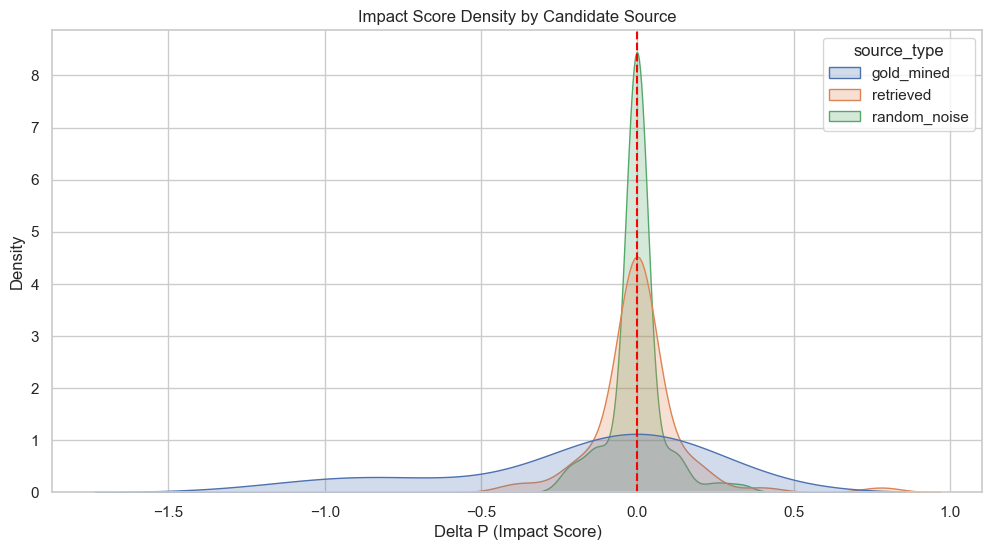

In [3]:
# Load Dataset Metadata
dataset_path = Path("../retrieval_dataset_verified.yaml")
if not dataset_path.exists():
    dataset_path = Path("retrieval_dataset_verified.yaml")

if not dataset_path.exists():
    raise FileNotFoundError("Dataset file not found.")

print(f"Loading metadata from: {dataset_path}")
with open(dataset_path, 'r') as f:
    data = yaml.safe_load(f)

cases = data.get('cases', [])
records = []
convergence_traces = []
for case in cases:
    if 'convergence_trace' in case.get('metadata', {}):
        convergence_traces.append({
            'case_id': case['id'],
            'trace': case['metadata']['convergence_trace']
        })
    candidates = case.get('candidates', [])
    for ctx in candidates:
        meta = ctx.get('metadata', { })
        records.append({
            'case_id': case['id'],
            'query': case['query'],
            'fqn': ctx['fqn'],
            'source_type': ctx['type'],
            'delta_p': meta.get('delta_p', 0.0),
            'n_in': meta.get('n_in', 0),
            'se_in': meta.get('se_in', 0.0),
        })
stats_df = pd.DataFrame(records)

if not stats_df.empty:
    plt.figure(figsize=(12, 6))
    sns.kdeplot(data=stats_df, x='delta_p', hue='source_type', fill=True, common_norm=False)
    plt.title('Impact Score Density by Candidate Source')
    plt.xlabel('Delta P (Impact Score)')
    plt.axvline(0, color='red', linestyle='--')
    plt.show()

## 3. Case-Level Convergence (Max Uncertainty)

This plot shows the **Maximum Standard Error** across all candidates for each case. This metric determines when we stop testing a case.

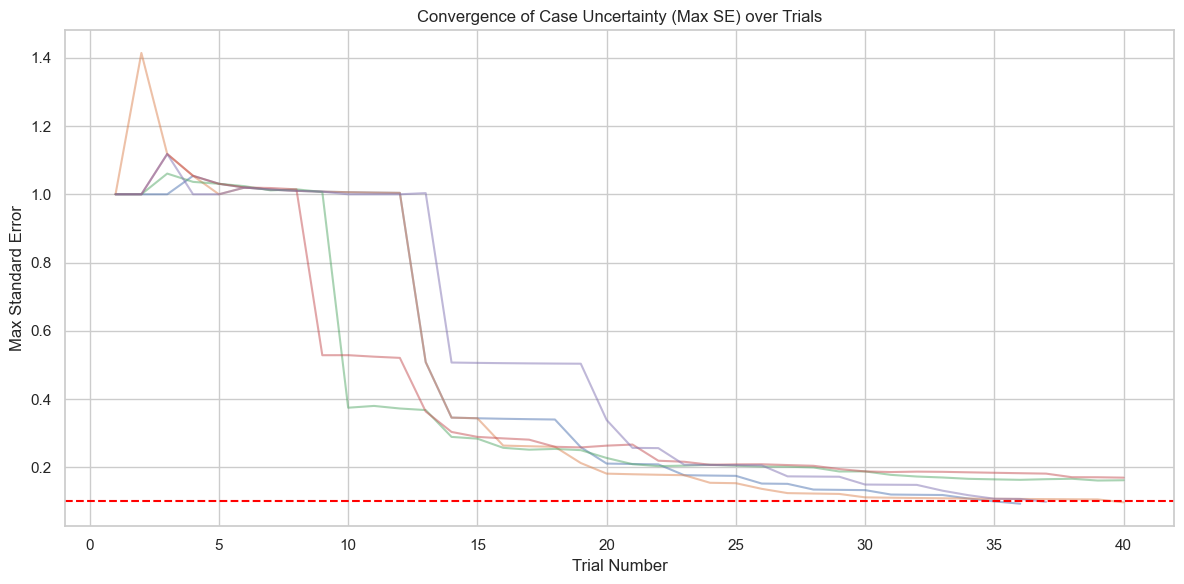

In [4]:
plt.figure(figsize=(12, 6))
for trace in convergence_traces:
    y = trace['trace']
    x = range(1, len(y) + 1)
    plt.plot(x, y, alpha=0.5, label=trace['case_id'][:20])

plt.title('Convergence of Case Uncertainty (Max SE) over Trials')
plt.xlabel('Trial Number')
plt.ylabel('Max Standard Error')
plt.axhline(0.1, color='red', linestyle='--', label='Threshold (0.1)')
plt.tight_layout()
plt.show()

## 4. Deep Dive: Per-Context Convergence

This visualization drills down into a single case, showing the uncertainty (Standard Error) for **each individual document** over time. 

**Interpretation:**
*   **Fan-out:** Lines start high (SE=1.0) and drop.
*   **Separation:** Some docs converge quickly (easy to judge), others stay high (noisy/ambiguous).
*   **The Governor:** The slowest-converging line (highest Y) is what holds up the entire case.

Analyzing specific convergence for case: configure_adk_features_mc:which_is_the_correct_import_statement_for_the_runn


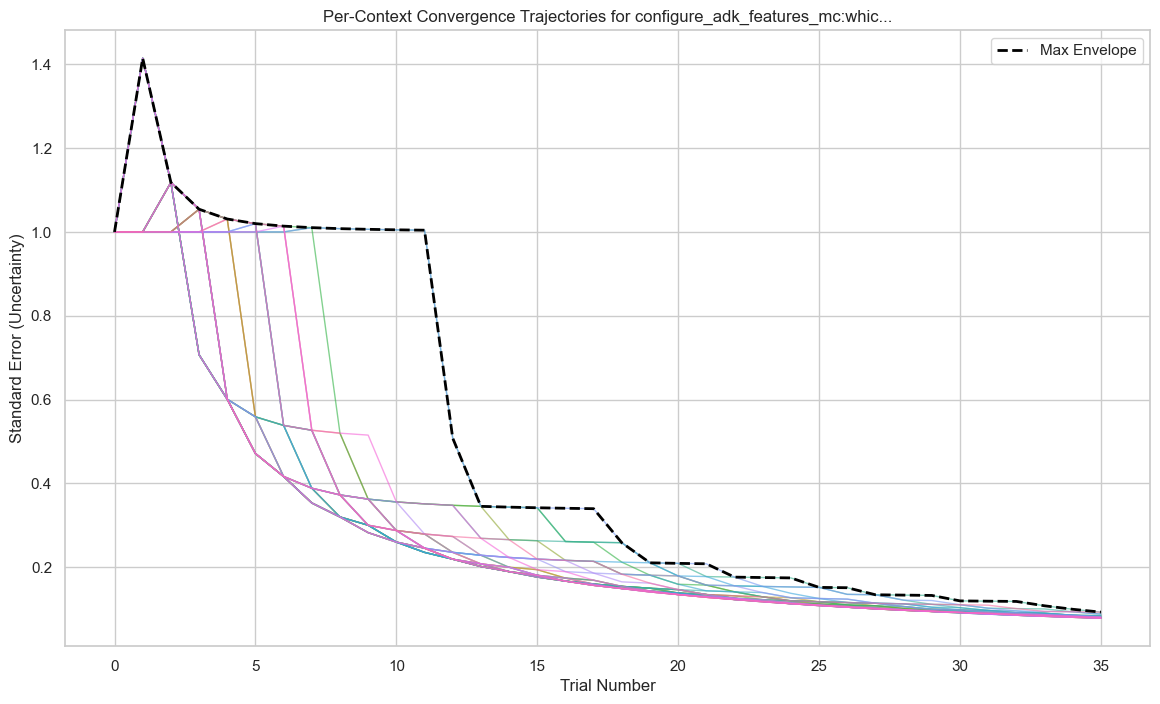

In [5]:
# Select the first case found in logs
if convergence_events:
    example_case_id = convergence_events[0]['case_id']
    print(f"Analyzing specific convergence for case: {example_case_id}")
    
    # Extract SE history for this case
    se_history = []
    for e in convergence_events:
        if e['case_id'] == example_case_id:
            # Strict check: se_map is guaranteed by Pydantic model
            if 'se_map' in e:
                for fqn, se in e['se_map'].items():
                    se_history.append({
                        'trial': e['trial_index'],
                        'fqn': fqn,
                        'standard_error': se
                    })
    
    se_df = pd.DataFrame(se_history)
    
    if not se_df.empty:
        plt.figure(figsize=(14, 8))
        sns.lineplot(data=se_df, x='trial', y='standard_error', hue='fqn', legend=False, alpha=0.6, linewidth=1)
        
        # Highlight the max envelope
        max_se_per_trial = se_df.groupby('trial')['standard_error'].max()
        plt.plot(max_se_per_trial.index, max_se_per_trial.values, color='black', linestyle='--', linewidth=2, label='Max Envelope')
        
        plt.title(f'Per-Context Convergence Trajectories for {example_case_id[:30]}...')
        plt.ylabel('Standard Error (Uncertainty)')
        plt.xlabel('Trial Number')
        plt.legend()
        plt.show()

## 5. Trial Dynamics (Success Rate)

This graph tracks the stability of the model's success rate over the course of the Monte Carlo trials.

*   **Rising Curve:** The model success rate is stable or improving as we sample more contexts.
*   **High Variance (Jagged):** The model is **brittle**. Its success depends heavily on exactly which subset of documents is present in the context. This indicates that the "Winning Coalition" is rare or fragile.

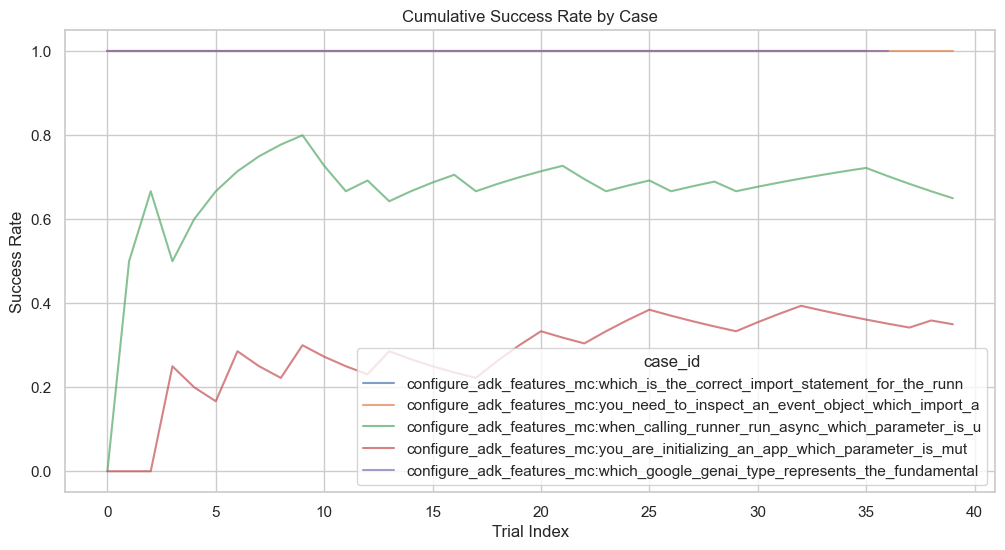

In [6]:
if not trials_df.empty:
    trials_df['success'] = trials_df['is_correct'].astype(int)
    trials_df['cumulative_success_rate'] = trials_df.groupby('case_id')['success'].expanding().mean().reset_index(level=0, drop=True)
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=trials_df, x='trial_index', y='cumulative_success_rate', hue='case_id', alpha=0.7)
    plt.title('Cumulative Success Rate by Case')
    plt.xlabel('Trial Index')
    plt.ylabel('Success Rate')
    plt.show()

## 6. Case Breakdown: Relevance Analysis

This section provides a detailed breakdown of candidate documents for each case, sorted by their causal relevance (Delta P).

**Legend:**
*   **$\Delta P > 0.1$:** **Primary Signal**. These documents are likely essential.
*   **Source Type:** Where this candidate came from (Gold Mining, Vector Search, or Random Noise).

In [7]:
if not stats_df.empty:
    # Group by Case ID
    cases_groups = stats_df.groupby('case_id')
    
    for case_id, group in cases_groups:
        print(f"\n### Case: {case_id}")
        # Get query text from records if available, otherwise just ID
        # In the dataframe we have query column
        query_text = group['query'].iloc[0] if 'query' in group.columns else "Unknown Query"
        print(f"**Query:** {query_text}")
        
        # Sort by Delta P descending
        sorted_group = group.sort_values('delta_p', ascending=False)
        
        # Display top 10 relevant and bottom 3 toxic
        relevant = sorted_group.head(5)
        toxic = sorted_group.tail(5)
        
        display_cols = ['fqn', 'delta_p', 'n_in', 'source_type']
        
        if not relevant.empty:
            print("\n**Top Relevant Contexts:**")
            print(relevant[display_cols].to_markdown(index=False))
        else:
            print("\n*No highly relevant contexts found.*")
            
        if not toxic.empty:
            print("\n**Toxic Contexts (Distractors):**")
            print(toxic[display_cols].to_markdown(index=False))


### Case: configure_adk_features_mc:when_calling_runner_run_async_which_parameter_is_u
**Query:** When calling `runner.run_async()`, which parameter is used to pass the user's input message?

**Top Relevant Contexts:**
| fqn                                                                        |   delta_p |   n_in | source_type   |
|:---------------------------------------------------------------------------|----------:|-------:|:--------------|
| google.adk.runners.Runner.run_async                                        |      0.78 |     22 | retrieved     |
| google.adk.runners.Runner.run_live                                         |      0.4  |     17 | retrieved     |
| google.adk.plugins.global_instruction_plugin                               |      0.28 |     27 | random_noise  |
| google.adk.plugins.base_plugin.BasePlugin.on_user_message_callback         |      0.23 |     18 | retrieved     |
| vertexai.preview.reasoning_engines.templates.adk.AdkApp.async_stream_query |      